# Data Wrangling for Model 4

This notebook is an alteration of the data wrangling process for model 3. With the goal of reducing the dimmensionality of the images by converting them into single channel binary images. I had realized the other day that the signature images being used in this project are essentially black and white. Converting to grayscale and then applying a thresholding function to the images would reduce the dimmemsionality of the images by 66% and simplify the task while still maintaining the integrity of the signature's lines within the image. It also reduced the task to a purely spatial one, which benefits convolution.

### The additions to this notebook from the one for Model 3 begin at Step 4.)
Other than this alteration, the data prep process is the same.

In [ ]:
import boto3
import os

# Initialize the S3 client
s3 = boto3.client('s3')

def download_folder_from_s3(bucket_name, s3_folder, local_path):
    paginator = s3.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket_name, Prefix=s3_folder):
        # Download each file individually
        for key in result.get('Contents', []):
            file_key = key.get('Key')
            if not os.path.exists(os.path.dirname(local_path + file_key)):
                os.makedirs(os.path.dirname(local_path + file_key))
            s3.download_file(bucket_name, file_key, local_path + file_key)

# Example usage
download_folder_from_s3('signature-data', 'test', 'test')
download_folder_from_s3('signature-data', 'train', 'train')


### Dataset Version 1
### 1.)
Below I am gather the paths to all the real signatures in the train and test directories.

In [1]:
import os

test_dir = r"C:\Users\hunte\OneDrive\Documents\Coding Projects\Signature-Similarity-Checker\data\signature-verification-dataset\sign_data\test"
train_dir = r"C:\Users\hunte\OneDrive\Documents\Coding Projects\Signature-Similarity-Checker\data\signature-verification-dataset\sign_data\train"

test_dir_contents = os.listdir(test_dir)
train_dir_contents = os.listdir(train_dir)

test_real_sig_path, train_real_sig_paths = [], []

# Get all the paths to the real signatures 
for subdir in test_dir_contents:
    if "forg" not in subdir:
        test_real_sig_path.append(os.path.join(test_dir, subdir))

for subdir in train_dir_contents:
    if "forg" not in subdir:
        train_real_sig_paths.append(os.path.join(train_dir, subdir))


#print first 5 paths of each list
print(test_real_sig_path[:5])
print(train_real_sig_paths[:5])

['C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Signature-Similarity-Checker\\data\\signature-verification-dataset\\sign_data\\test\\049', 'C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Signature-Similarity-Checker\\data\\signature-verification-dataset\\sign_data\\test\\050', 'C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Signature-Similarity-Checker\\data\\signature-verification-dataset\\sign_data\\test\\051', 'C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Signature-Similarity-Checker\\data\\signature-verification-dataset\\sign_data\\test\\052', 'C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Signature-Similarity-Checker\\data\\signature-verification-dataset\\sign_data\\test\\053']
['C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Signature-Similarity-Checker\\data\\signature-verification-dataset\\sign_data\\train\\001', 'C:\\Users\\hunte\\OneDrive\\Documents\\Coding Projects\\Signature-Similarity-Checker\\data\\signature-verifi

### 2.)
I call the get_tensor_images() function to load in the list of image paths from above, apply appropriate tensor transformations to them, and return as a labels and features tensor.

In [2]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Initializes tranforms to apply to images
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))



def get_tensor_labels_features(tensor_image_list, path_list):
    '''
        This function recieves a list of paths to directories containing multiple images, where the 
        name of the directory is the label for the images in the directory. The function iterates 
        through each path, converts the images to tensors and resizes to 3x224x224, and appends them 
        to a list. The function also creates a list of labels for each image in the path. These lists 
        are converted to tensors and stacked. The function returns a tensor of labels and a tensor of
        images.
    '''

    labels = []

    # iterate through each path in the list
    for path in path_list:

        # get label from path name (last element in path)
        label = int(path.split("\\")[-1])

        # initialize list to hold labels for each image in the path
        dir_labels = []

        # iterate through each file in the path
        for file in os.listdir(path):

            # convert image to tensor
            tensor_image = transform(Image.open(os.path.join(path, file)))

            # resize images to 224x224
            tensor_image = resize(tensor_image)

            # append tensor to list
            tensor_image_list.append(tensor_image)
            
            # append single item tensors to list of labels for the path
            dir_labels.append(torch.tensor(label))

        # append list of labels to labels list after stacking
        labels.append(torch.stack(dir_labels))

    # concat list of tensor stacks into one tensor --- and stacked images into one tensor  --- and return
    return torch.cat(labels), torch.stack(tensor_image_list)



            


# intitialize lists to hold images as tensors
test_real_sig_images, train_real_sig_images = [], []

# get tensor images
test_labels, test_images = get_tensor_labels_features(test_real_sig_images, test_real_sig_path)
train_labels, train_images = get_tensor_labels_features(train_real_sig_images, train_real_sig_paths)

c:\Users\hunte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
#print shapes
print(f'Test Images Shape: {test_images.shape}')
print(f'Test Labels Shape: {test_labels.shape}\n')

print(f'Train Images Shape: {train_images.shape}')
print(f'Train Labels Shape: {train_labels.shape}')


Test Images Shape: torch.Size([252, 3, 224, 224])
Test Labels Shape: torch.Size([252])

Train Images Shape: torch.Size([887, 3, 224, 224])
Train Labels Shape: torch.Size([887])


### 3.) 
Below are the new additions to the data wrangling process for model 3. It involves a process fo taking the above train and test tensors, which contain uneven distributions of classes between them, and reorganizing them to keep the 80/20 num examples split while having a uniform number of each class in each set.


The first step is to contcatenate the images and labels toegether.


In [4]:
# concate test and train images and labels
images = torch.cat([test_images, train_images])
labels = torch.cat([test_labels, train_labels])

Next, the above image and labels tensors are passed into the below function, which reorganizes the class distribution between train and test.

In [5]:
def get_train_test_sets(images, labels, train_split=0.8):
    '''
        This function iterates through the the labels tensor and extracts all unique labels.
        These labels are then iterated through to extract out all images from the images tensor
        that share that label. The images are then split up into the train and test sets based om
        the train_split parameter. The function returns a train and test tensor.

    '''


    #initialize list to hold unique labels
    unique_labels = []

    # iterate through number of examples to get unique labels
    for i in range(len(labels)):

        # get label of current iteration
        label = int(labels[i])

        if label not in unique_labels:
            unique_labels.append(label)


    # initialize dict to hold list of images for each unique label
    label_img_dict = {}
        
    for unique_label in unique_labels:   

        # intitialize list to hold images sharing a unique label
        like_images = []
        
        # iterate through labels tensor
        for (label, image) in zip(labels, images):

            # convert label to int
            label = int(label)

            # append only images that share the unique label
            if label == unique_label:
                like_images.append(image)

        # add list of images to dictionary with their label as key
        label_img_dict[unique_label] = like_images

    # initialize lists to hold train and test images\labels
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    # iterate through dictionary of labels and images
    for key, value in label_img_dict.items():

        # compute the train split index 
        train_split_index = int(len(value) * train_split)

        # append train images and labels
        train_images.extend(value[:train_split_index])
        train_labels.extend([key] * train_split_index)  # set num indicies in train_split to key

        # append test images and labels
        test_images.extend(value[train_split_index:]) 
        test_labels.extend([key] * (len(value) - train_split_index)) # set num indicies in test_split to key

    # stack train and test images and labels
    train_images = torch.stack(train_images)
    train_labels = torch.stack([torch.tensor(label) for label in train_labels])

    test_images = torch.stack(test_images)
    test_labels = torch.stack([torch.tensor(label) for label in test_labels])

    # return train and test images and labels
    return train_images, train_labels, test_images, test_labels


In [6]:
# get train and test images and labels
train_images, train_labels, test_images, test_labels = get_train_test_sets(images, labels)

# print shapes
print(f'Train Images Shape: {train_images.shape}')
print(f'Train Labels Shape: {train_labels.shape}\n')
print(f'Test Images Shape: {test_images.shape}')
print(f'Test Labels Shape: {test_labels.shape}')

Train Images Shape: torch.Size([885, 3, 224, 224])
Train Labels Shape: torch.Size([885])

Test Images Shape: torch.Size([254, 3, 224, 224])
Test Labels Shape: torch.Size([254])


# 4.) 
Reduce to grayscale ---> Reduce to Binary cmap

In [17]:
def convert_binary_cmap(tensor_images, threshold=0.9):
    '''
        This function takes as input an image tensor stack of shape
        [num_images, 3 (channels), height, width] and converts it to
        a [num_images, 1, height, width] tensor stack, where the channel
        values in the 1 dim are either 0 or 1 for dimmensionality reduction.
    '''
    
    # ----- ----- Grayscale Conversion ----- ----- #

    # [0.299, 0.587, 0.114] are the weights for the RGB channels commonly used 
    # in ITU-R BT.601-7 standard. Which is a tool for converting RGB images to
    # grayscale images. 

    # First, a tensor of the ITU-R BT.601-7 weights is created with shape [1, 3, 1, 1] 
    gray_weights = torch.tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)

    # The gray_weights [1, 3, 1, 1] tensors is then broadcasted to the shape of the image
    # data, [num_images, 3, height, width], and multiplied by the image data. This result
    # is then summed across the channels dimmension (dim=1) to get a grayscale image.
    gray_image = (tensor_images * gray_weights).sum(dim=1, keepdim=True)


    # Convert to binary black and white by thresholding
    binary_image = (gray_image > threshold).float()

    return binary_image

Calling the above function on the train and test sets

In [23]:
train_binary = convert_binary_cmap(train_images)
test_binary = convert_binary_cmap(test_images)

In [24]:
print(f'Train Binary Images Shape: {train_binary.shape}')
print(f'Test Binary Images Shape: {test_binary.shape}')

Train Binary Images Shape: torch.Size([885, 1, 224, 224])
Test Binary Images Shape: torch.Size([254, 1, 224, 224])


These functions are used to plot two tensors images

In [34]:
import matplotlib.pyplot as plt
import numpy as no

def convert_img_tensor(img_tensor):

    # convert to channels last
    img_tensor = img_tensor.permute(1, 2, 0)

    # convert to numpy and return
    return img_tensor.detach().numpy()


def plot_imgs(img_tensor_1, image_tensor_2):

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    img_tensor_1 = convert_img_tensor(img_tensor_1)
    image_tensor_2 = convert_img_tensor(image_tensor_2)

    ax[0].imshow(img_tensor_1, cmap='gray')
    ax[1].imshow(image_tensor_2, cmap='gray')

    plt.show()

Here is a plot of two of the binary images.

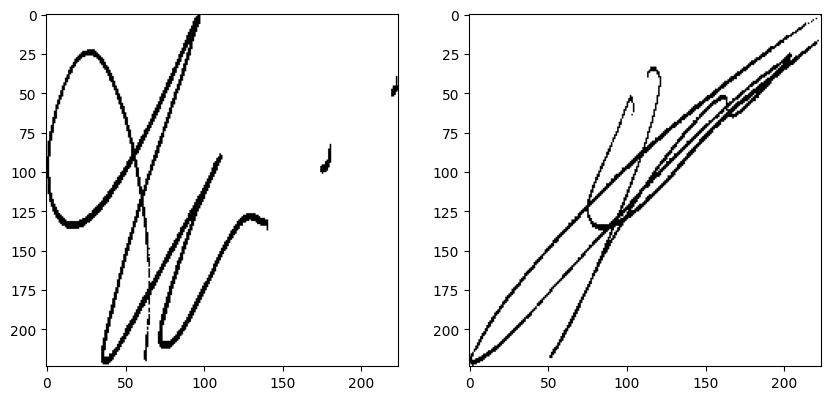

In [35]:
plot_imgs(train_binary[0], train_binary[56])

Now these are ready for training. They just need to be converted to tensor datasets and wrapped in data loaders.

In [14]:
# save tensors to file
torch.save(test_images, "test_images.pt")
torch.save(test_labels, "test_labels.pt")
torch.save(train_images, "train_images.pt")
torch.save(train_labels, "train_labels.pt")